<a href="https://colab.research.google.com/github/ShaniOrhof/image_processing_final_project/blob/main/DLC_result_processos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the DeepLabcut result testing page


this form allows for quick and easy assesment of the results of DeepLabcut video processing for mice behaviur videos from the Forkosh lab

**Before we begin, please ensure you are using the Chrome web browser.** <br>


# Part One - Set up


---



here we will run the code that will allow this whole thing to work, **run this part first** <br>
please allow the notebook to connect to your google drive to access the files

In [19]:
#@title  Run Set Up  { display-mode: "form" }

#import needed moudles
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
from IPython.display import Video
from google.colab import files
import shutil
import time

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#set up needed functions

def load_dlc_csv(csv_path):
    """
    Loads and processes a DeepLabCut (DLC) CSV file into a structured DataFrame.

    Parameters:
    - csv_path (str): Path to the DLC output CSV file.

    Returns:
    - pd.DataFrame: Processed DataFrame with MultiIndex columns (individual, body_part, coord).
    """
    # Load CSV while handling multi-index columns
    df = pd.read_csv(csv_path, header=[0, 1, 2, 3], low_memory=False)

    # Drop first column if it's just an index column
    df = df.drop(columns=df.columns[0])

    # Ensure proper MultiIndex structure
    df.columns = df.columns.droplevel(0)  # Remove model name
    df.columns = pd.MultiIndex.from_tuples(df.columns, names=["individual", "body_part", "coord"])

    # Standardize levels (string type, remove spaces)
    df.columns = df.columns.set_levels(df.columns.levels[1].astype(str).str.strip(), level=1)
    df.columns = df.columns.set_levels(df.columns.levels[2].astype(str).str.lower(), level=2)

    return df


def test_DLC_on_frame(df, video_path, frame_number=None):
    """
    Plots DeepLabCut (DLC) tracked body parts on a selected video frame with separate legends for body parts and individuals.

    Parameters:
    - df (pd.DataFrame): DataFrame containing DLC tracking data with MultiIndex columns, as created by load_dlc_csv().
    - video_path (str): Path to the video file.
    - frame_number (int, optional): Specific frame number to analyze. If None, a random frame is selected.

    Returns:
    - None (displays a plot of the frame with markers for detected body parts).
    """

    # Define color mappings for individuals
    color_map = {'R': 'red', 'G': 'green', 'B': 'blue', 'Y': 'yellow'}

    # Define marker shapes for body parts
    marker_map = {
        'nose': 'o', 'L_ear': 'P', 'R_ear': 'X',
        'T_base': '^', 'T_end': 'v', 'T_mid': '>',
        'L_flnk': 'D', 'R_flnk': 'd', 'cntr': '*'
    }

    # Select a random frame if no frame number is provided
    num_frames = len(df)
    if frame_number is None:
        frame_number = np.random.randint(0, num_frames)

    # Load the video and extract the frame
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"Failed to read video frame {frame_number}.")
        return

    # Convert frame to RGB (OpenCV loads in BGR by default)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Extract data for the selected frame (keep MultiIndex structure)
    frame_data = df.iloc[[frame_number]]
    body_parts = df.columns.get_level_values(1).unique()
    individuals = df.columns.get_level_values(0).unique()

    # Extract the filename from the path
    video_filename = os.path.basename(video_path)

    # Create the figure and adjust spacing
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.imshow(frame)

    # Store legend elements separately
    body_part_legend = []
    individual_legend = []

    # Track which legends have already been added (to avoid duplicates)
    added_body_parts = set()
    added_individuals = set()

    # Loop through individuals and body parts to plot key points
    for individual in individuals:
        try:
            id_df = frame_data.xs(individual, level=0, axis=1)  # Extract data for this individual
            color = color_map.get(individual, 'black')  # Default to black if identity is missing

            # Add individual to legend only once, with the color name in label
            if individual not in added_individuals:
                label = f"{individual}: {color.capitalize()}"  # Example: "R: Red"
                individual_legend.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=10, label=label))
                added_individuals.add(individual)

            for part in body_parts:
                try:
                    x_values = id_df.xs((part, 'x'), level=(0, 1), axis=1).values.flatten()
                    y_values = id_df.xs((part, 'y'), level=(0, 1), axis=1).values.flatten()
                    marker = marker_map.get(part, 'x')  # Default to 'x' if body part is missing

                    if len(x_values) > 0 and not np.isnan(x_values).all():
                        ax.scatter(x_values, y_values, color=color, marker=marker, s=60, edgecolors='black')

                        # Add body part to legend only once
                        if part not in added_body_parts:
                            body_part_legend.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=10, label=part))
                            added_body_parts.add(part)

                except KeyError:
                    continue

        except KeyError:
            continue

    # Create two separate legends outside the frame
    legend1 = ax.legend(handles=body_part_legend, title="Body Parts", loc='upper left', bbox_to_anchor=(1, 1))
    legend2 = ax.legend(handles=individual_legend, title="Individuals", loc='upper left', bbox_to_anchor=(1, 0.7))

    ax.add_artist(legend1)  # Ensure both legends are displayed

    # Set title with video filename and frame number
    plt.title(f"{video_filename} - Frame {frame_number}")

    plt.show()


def create_DLC_labeled_video(df, video_path, output_path, start_frame=0, n_frames=300, fps=30):
    """
    Creates a short video with n consecutive frames from the original video,
    overlaying DeepLabCut (DLC) tracked body parts with static legends.

    Parameters:
    - df (pd.DataFrame): DataFrame containing DLC tracking data with MultiIndex columns.
    - video_path (str): Path to the original video file.
    - output_path (str): Path to save the output video.
    - start_frame (int): Starting frame number.
    - n_frames (int): Number of consecutive frames to process.
    - fps (int): Frames per second for the output video.

    Returns:
    - None (saves the video file).
    """

    # Define color mappings for individuals
    color_map = {'R': 'red', 'G': 'green', 'B': 'blue', 'Y': 'yellow'}

    # Define marker shapes for body parts
    marker_map = {
        'nose': 'o', 'L_ear': 'P', 'R_ear': 'X',
        'T_base': '^', 'T_end': 'v', 'T_mid': '>',
        'L_flnk': 'D', 'R_flnk': 'd', 'cntr': '*'
    }

    # Extract the filename from the path
    video_filename = os.path.basename(video_path)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID' for .avi
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width + 200, frame_height))  # Extra space for legend

    # Create static legend elements
    legend_body_parts = [plt.Line2D([0], [0], color='black', marker=m, linestyle='', markersize=10, label=part)
                         for part, m in marker_map.items()]

    legend_individuals = [plt.Line2D([0], [0], color=c, marker='o', linestyle='', markersize=10, label=ind)
                          for ind, c in color_map.items()]

    for frame_number in range(start_frame, start_frame + n_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if not ret:
            print(f"Failed to read frame {frame_number}.")
            continue

        # Convert frame to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if frame_number >= len(df):
            break

        frame_data = df.iloc[[frame_number]]
        body_parts = df.columns.get_level_values(1).unique()
        individuals = df.columns.get_level_values(0).unique()

        # Create figure with extra space for the legend
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.imshow(frame_rgb)
        ax.set_title(f"{video_filename} - Frame {frame_number}")
        ax.axis('off')

        # Plot key points
        for individual in individuals:
            try:
                id_df = frame_data.xs(individual, level=0, axis=1)
                color = color_map.get(individual, 'black')

                for part in body_parts:
                    try:
                        x_values = id_df.xs((part, 'x'), level=(0, 1), axis=1).values.flatten()
                        y_values = id_df.xs((part, 'y'), level=(0, 1), axis=1).values.flatten()
                        marker = marker_map.get(part, 'x')

                        if len(x_values) > 0 and not np.isnan(x_values).all():
                            ax.scatter(x_values, y_values, color=color, marker=marker, s=35, edgecolors='black')

                    except KeyError:
                        continue

            except KeyError:
                continue

        # Create legends outside the image
        legend_ax = fig.add_axes([0.85, 0.2, 0.1, 0.4])  # Position legend outside the frame
        legend_ax.axis('off')
        legend_ax.legend(handles=legend_body_parts, title="Body Parts", loc='upper left')

        legend_ax2 = fig.add_axes([0.85, 0.6, 0.1, 0.2])
        legend_ax2.axis('off')
        legend_ax2.legend(handles=legend_individuals, title="Individuals", loc='upper left')

        # Save frame as an image
        temp_image_path = f"temp_frame_{frame_number}.png"
        plt.savefig(temp_image_path, bbox_inches='tight', pad_inches=0, dpi=100)
        plt.close(fig)

        # Read saved image and write to video
        img = cv2.imread(temp_image_path)
        img_resized = cv2.resize(img, (frame_width + 200, frame_height))  # Resize to include legend space
        out.write(img_resized)

        os.remove(temp_image_path)

    cap.release()
    out.release()
    print(f"Video saved to {output_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part Two - upload the video and the results


---



here you need to uploade from your drive the video used in the deeplabcut analysis and CSV file holding the results. <br>

In [9]:
# @title Upload Files { display-mode: "form" }

# @markdown ### Enter file paths:
# @markdown ---
# @markdown #### Video path:
video_path = "/content/drive/MyDrive/Masters/Classes/image analysis/DLC attempts/SHORT.exp0051.day02.cam01.mp4"  # @param {type:"string"}

# @markdown ---
# @markdown #### Results path:
csv_path = "/content/drive/MyDrive/Masters/Classes/image analysis/DLC attempts/30.01 shuffle5/SHORT.exp0051.day02.cam01DLC_resnet50_trackAug31shuffle5_100000_el.csv"  # @param {type:"string"}

# Check if the video file is an MP4
if not video_path.lower().endswith(".mp4"):
    raise ValueError("🚨 Error: The selected video file is not an MP4. Please upload a .mp4 file.")

# Check if the results file is a CSV
if not csv_path.lower().endswith(".csv"):
    raise ValueError("🚨 Error: The selected results file is not a CSV. Please upload a .csv file.")

# Convert CSV to DataFrame
df = load_dlc_csv(csv_path)
num_frames = len(df)

# Part Three - test a single frame


---



here you can test the labeling of the DLC on a single frame of the video. you can repet this test as many time as you'd like <br>





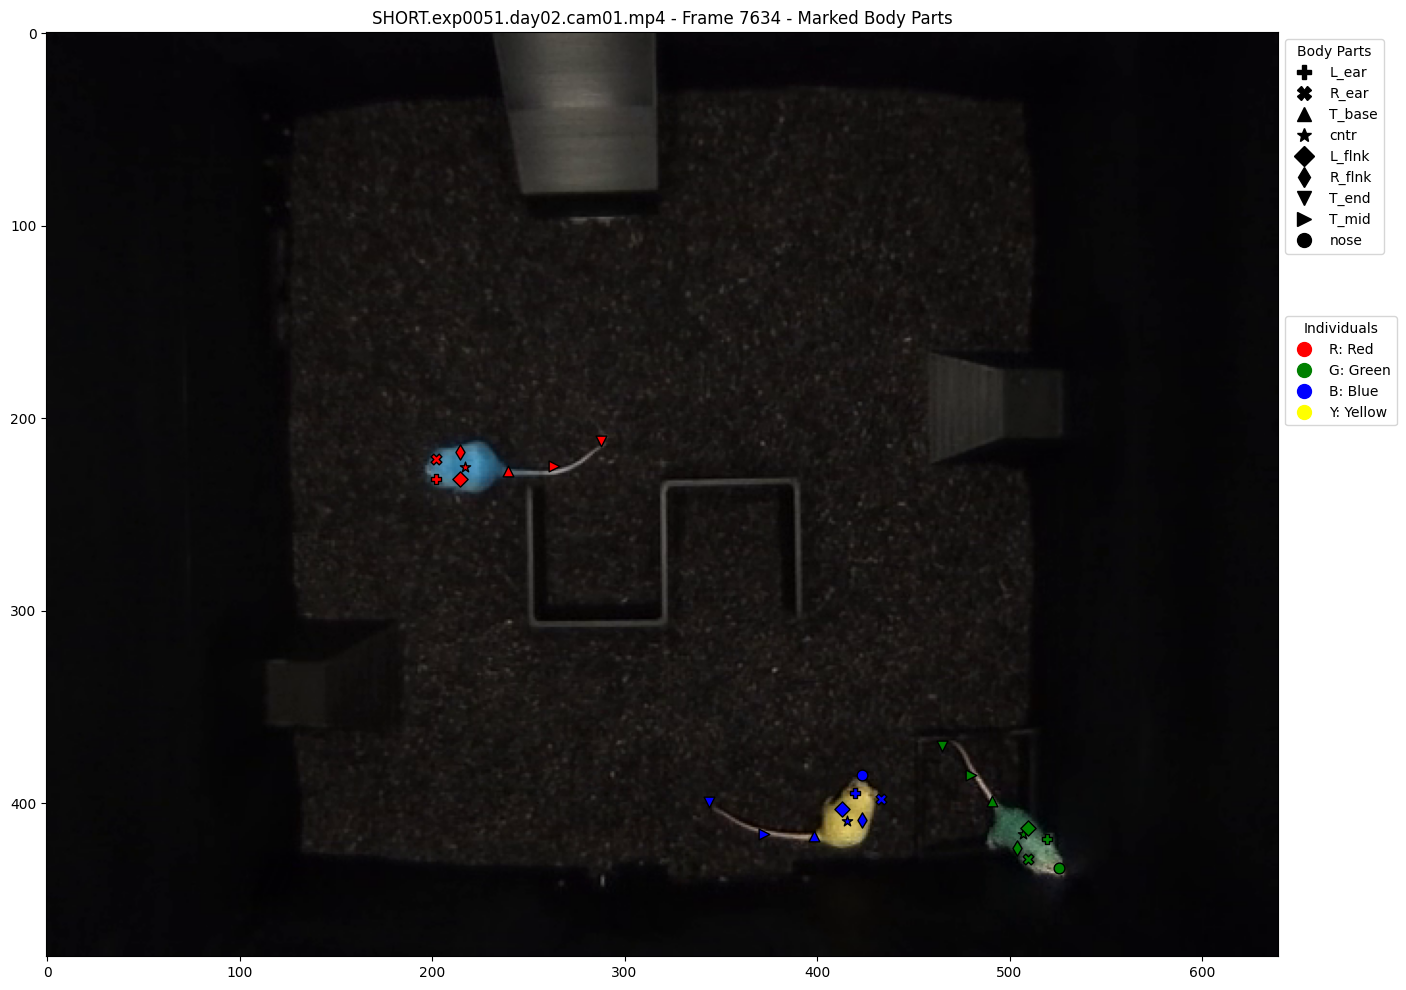

In [12]:
# @title generat a single test frame { display-mode: "form" }

#ask for a frame number to be displayed

# @markdown ### Optional - pick a frame number to display
# @markdown #### if no number is writen a random frame will be picked
frame_number = 0 # @param {type:"integer"}


# run test function while handling frame number outside of the video range
if frame_number > num_frames or frame_number < 0:
  print(f"the video has {num_frames} frames. please pick a number between 1 and {num_frames} ")
elif frame_number == 0:
  test_DLC_on_frame(df, video_path,frame_number = None)
else:
  test_DLC_on_frame(df, video_path, frame_number)



# Part four - generate a test video


---



here you can create a labeled video displaying the results.
depenting on the length of the video you wish to create this could take a few minutes <br>





In [22]:
# @title create the video { display-mode: "form" }

# @markdown ## Define video parameters
# @markdown #### Starting frame from the origional video
start_frame = 0 # @param {type:"integer"}

# @markdown #### the number of frames used in the video
n_frames = 50 # @param {type:"integer"}


# Ensure start_frame is within range
if start_frame < 0:
    print("⚠️ Warning: start_frame cannot be negative. Setting to 0.")
    start_frame = 0
elif start_frame >= num_frames:
    print(f"⚠️ Warning: start_frame is beyond the video length ({num_frames} frames). Setting to {num_frames - 1}.")
    start_frame = num_frames - 1

# Ensure n_frames does not exceed available frames
if start_frame + n_frames > num_frames:
    print(f"⚠️ Warning: n_frames exceeds available frames. Adjusting to {num_frames - start_frame}.")
    n_frames = num_frames - start_frame

# @markdown #### playback speed
playback_speed = 0.25 # @param {type:"slider", min:0.25, max:2, step:0.25}
fps = 30 * playback_speed


# name of output file
output_video = "DLC_labeled_video.mp4"

#generate video
create_DLC_labeled_video(df, video_path, output_video, start_frame, n_frames, fps)

# display video

# Convert video to ensure compatibility
!ffmpeg -y -loglevel error -i DLC_labeled_video.mp4 -vcodec libx264 -preset fast output_video.mp4

# Wait a bit to ensure encoding is complete
time.sleep(2)

# Display the video
Video("output_video.mp4", embed=True)


Video saved to DLC_labeled_video.mp4


In [16]:
# @title optional - download the video { display-mode: "form" }

# @markdown ## Run this section if you wish to download the video to your computer

# @markdown #### Enter a name for the downloaded file
download_name = "labeled_video"  # @param {type:"string"}

# Ensure the file has the .mp4 extension
if not download_name.endswith(".mp4"):
    download_name += ".mp4"

# Rename the file before downloading

shutil.copy(output_video, download_name)

# Download the file with the chosen name
files.download(download_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>